# Example GRE
for the Ph.D. Training program of the German Chapter of the ISMRM

https://github.com/pulseq/MR-Physics-with-Pulseq/tree/main/tutorials/01_basic_sequences/notebooks

In [19]:
!pip show pypulseq || pip install install git+https://github.com/imr-framework/pypulseq.git
!wget https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py

Name: pypulseq
Version: 1.4.0
Summary: Pulseq in Python
Home-page: https://github.com/imr-framework/pypulseq
Author: Keerthi Sravan Ravi
Author-email: ks3621@columbia.edu
License: License :: OSI Approved :: GNU Affero General Public License v3
Location: /usr/local/lib/python3.10/dist-packages
Requires: coverage, matplotlib, numpy, scipy, sigpy
Required-by: MRzeroCore
--2024-02-07 15:14:47--  https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36249 (35K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  35.40K  --.-KB/s    in 0.003s  

2024-02-07 15:14:48 (10.3 MB/s) - ‘utils.py’ saved [36249/36249]



In [2]:
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as mr
import utils # several helper functions for simulation and recon

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


In [3]:
# SETUP

fov=256e-3
dwell=10e-5
Nread=64
Nphase=1
TE=5e-3
TR=60e-3


# Set system limits
system = mr.Opts(
    max_grad=32,
    grad_unit="mT/m",
    max_slew=130,
    slew_unit="T/m/s",
    rf_ringdown_time=30e-6,
    rf_dead_time=100e-6,
)

# Create 90 degree slice selection pulse and gradient
rf_ex, gz1, _ = mr.make_sinc_pulse(
    flip_angle=90 * np.pi / 180,
    system=system,
    duration=1e-3,
    slice_thickness=5e-3,
    apodization=0.5,
    time_bw_product=4,
    phase_offset=0* np.pi / 180,
    return_gz=True,
)

gx =mr.make_trapezoid(channel='x', flat_area=Nread/fov,flat_time=Nread*dwell)
gx_pre =mr.make_trapezoid(channel='x', area=-gx.area/2,duration=1e-3)


print(f"""The bandwidth is {1/dwell:.2f} Hz
and {1/(dwell*Nread):.2f} Hz/px for the {Nread*dwell*1000:.2f} ms ADC.""")

adc = mr.make_adc(
    num_samples=Nread,
    duration=Nread*dwell,
    phase_offset=0* np.pi / 180,
    system=system,)


The bandwidth is 10000.00 Hz
and 156.25 Hz/px for the 6.40 ms ADC.


In [4]:
# CONSTRUCT SEQUENCE
# Create a new sequence object
seq = mr.Sequence(system)
seq.add_block(rf_ex)
seq.add_block(gx_pre)
adc.delay=gx.rise_time
seq.add_block(adc,gx)

In [5]:
# check sequence timing
(ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

Timing check passed successfully


#Visualization and Export

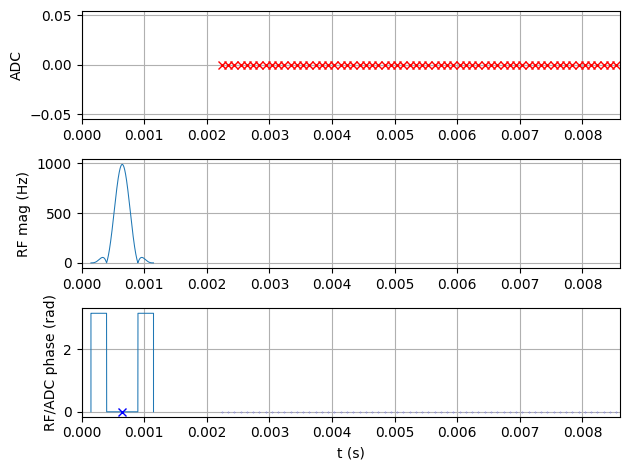

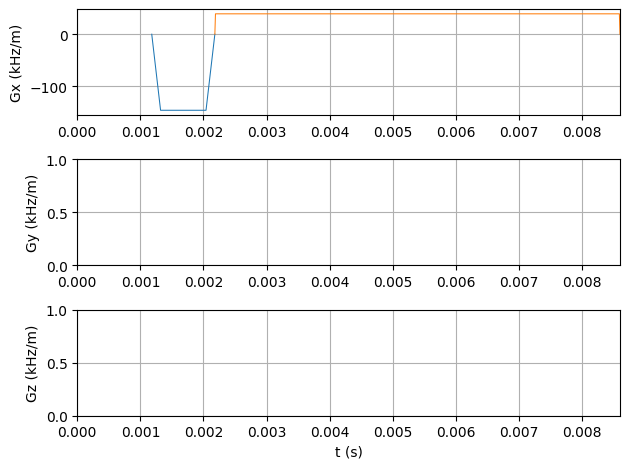

zoom in


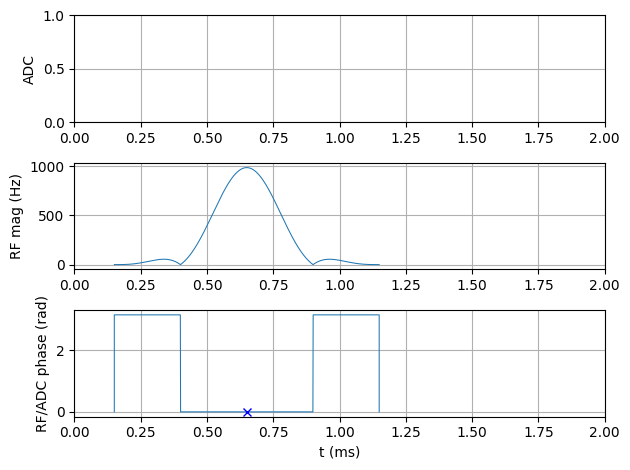

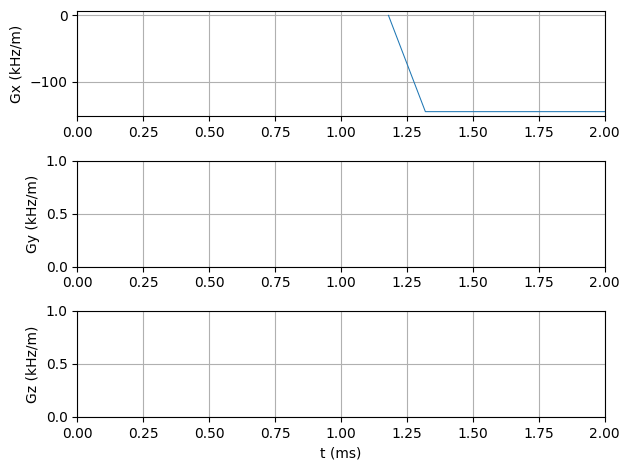

In [6]:
#@title plot sequence
# plot the entire sequence
seq.plot()


# plot just a small initial part
print('zoom in')
seq.plot(time_range=[0, 0.002], time_disp="ms") #


In [7]:
#@title write seq file and export
seq_filename='FID.seq'
seq.write(seq_filename)
from google.colab import files
files.download(seq_filename)  # Download locally

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Simulation

In [15]:
#@title simulation setup
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
import MRzeroCore as mr0
import utils # several helper functions for simulation and recon

In [20]:
#@title simulation (simple)
# kscape_adc.shape is [N_coils, N_meas, N_adc]
kspace_adc=utils.simulate_2d(seq, noise_level=0, n_coils=1, dB0=+10, B0_scale=1, B0_polynomial=None)
#sp_adc, t_adc = util.pulseq_plot(seq,signal=kspace_adc) # for pypulseq below dev branch.
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq, kspace_adc)
plt.show()


RuntimeError: simulate_2d called, but MRzeroCore is not available. Run: !pip install mrzerocore

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


CustomVoxelPhantom
Voxel shape: box
Voxel size: tensor([0.1000, 0.1000, 0.1000])


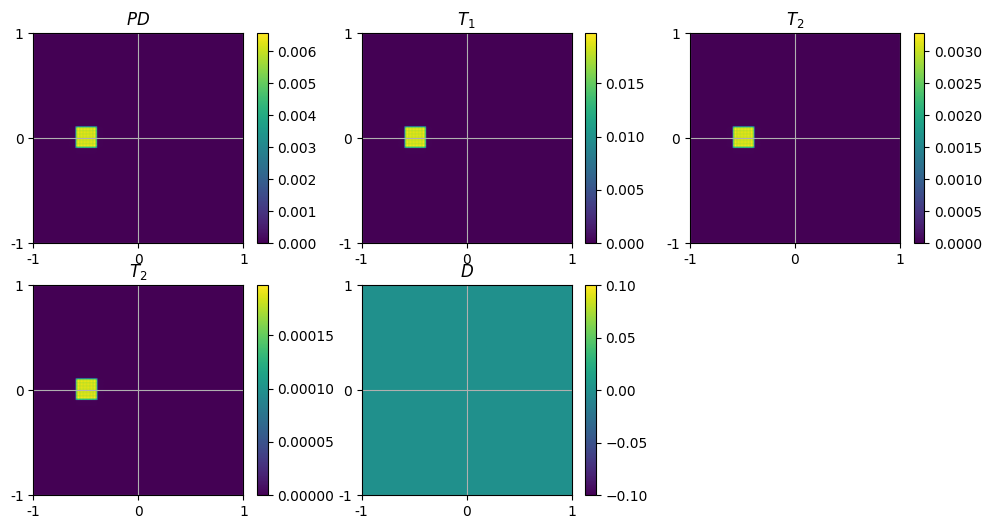

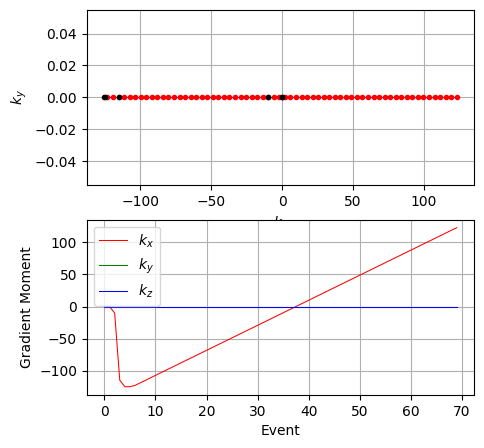

Calculating repetition 1 / 1 - done


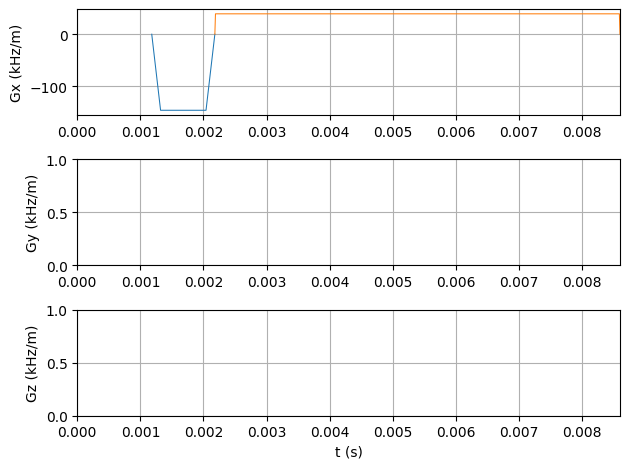

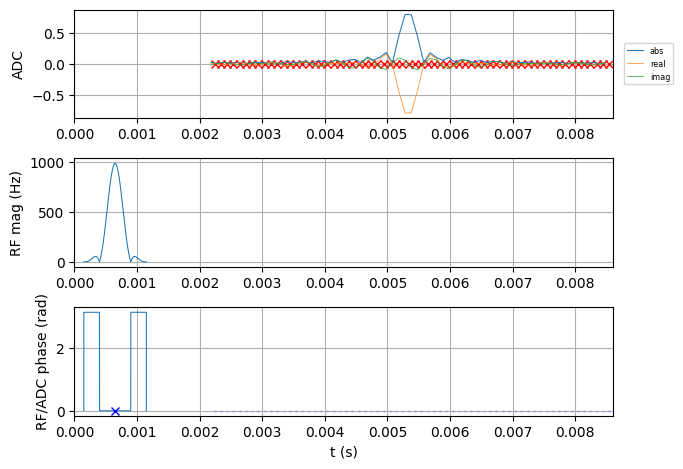

In [21]:
#@title simulation (advanced)
# %%  1D GRE in a pixel phantom - simulation
dB0 = 0
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
# set phantom  manually to a pixel phantom. Coordinate system is [-0.5, 0.5]^3
obj_p = mr0.CustomVoxelPhantom(
        pos=[[-0.25, 0., 0]],
        PD=[1.0],
        T1=[3.0],
        T2=[0.5],
        T2dash=[30e-3],
        D=[0.0],
        B0=0,
        voxel_size=0.1,
        voxel_shape="box"
    )
# Manipulate loaded data
obj_p.B0+=dB0
obj_p.D*=0
obj_p.plot()
# Convert Phantom into simulation data
obj_p=obj_p.build()


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot

# Read in the sequence
seq0 = mr0.Sequence.import_file(seq_filename)
seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, max_state_count=1000, min_state_mag=1e-5)
signal = mr0.execute_graph(graph, seq0, obj_p)

# PLOT sequence with signal in the ADC subplot
#sp_adc, t_adc = util.pulseq_plot(seq,signal=kspace_adc) # for pypulseq below dev branch.
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq, signal)
plt.show()